# Generating Text with RNNs: The Jules Verne Bot
- By Marcelo Rovai @Nov24
- With code support from **Claude 3.5 Sonnet** and **ChatGPT 4o**

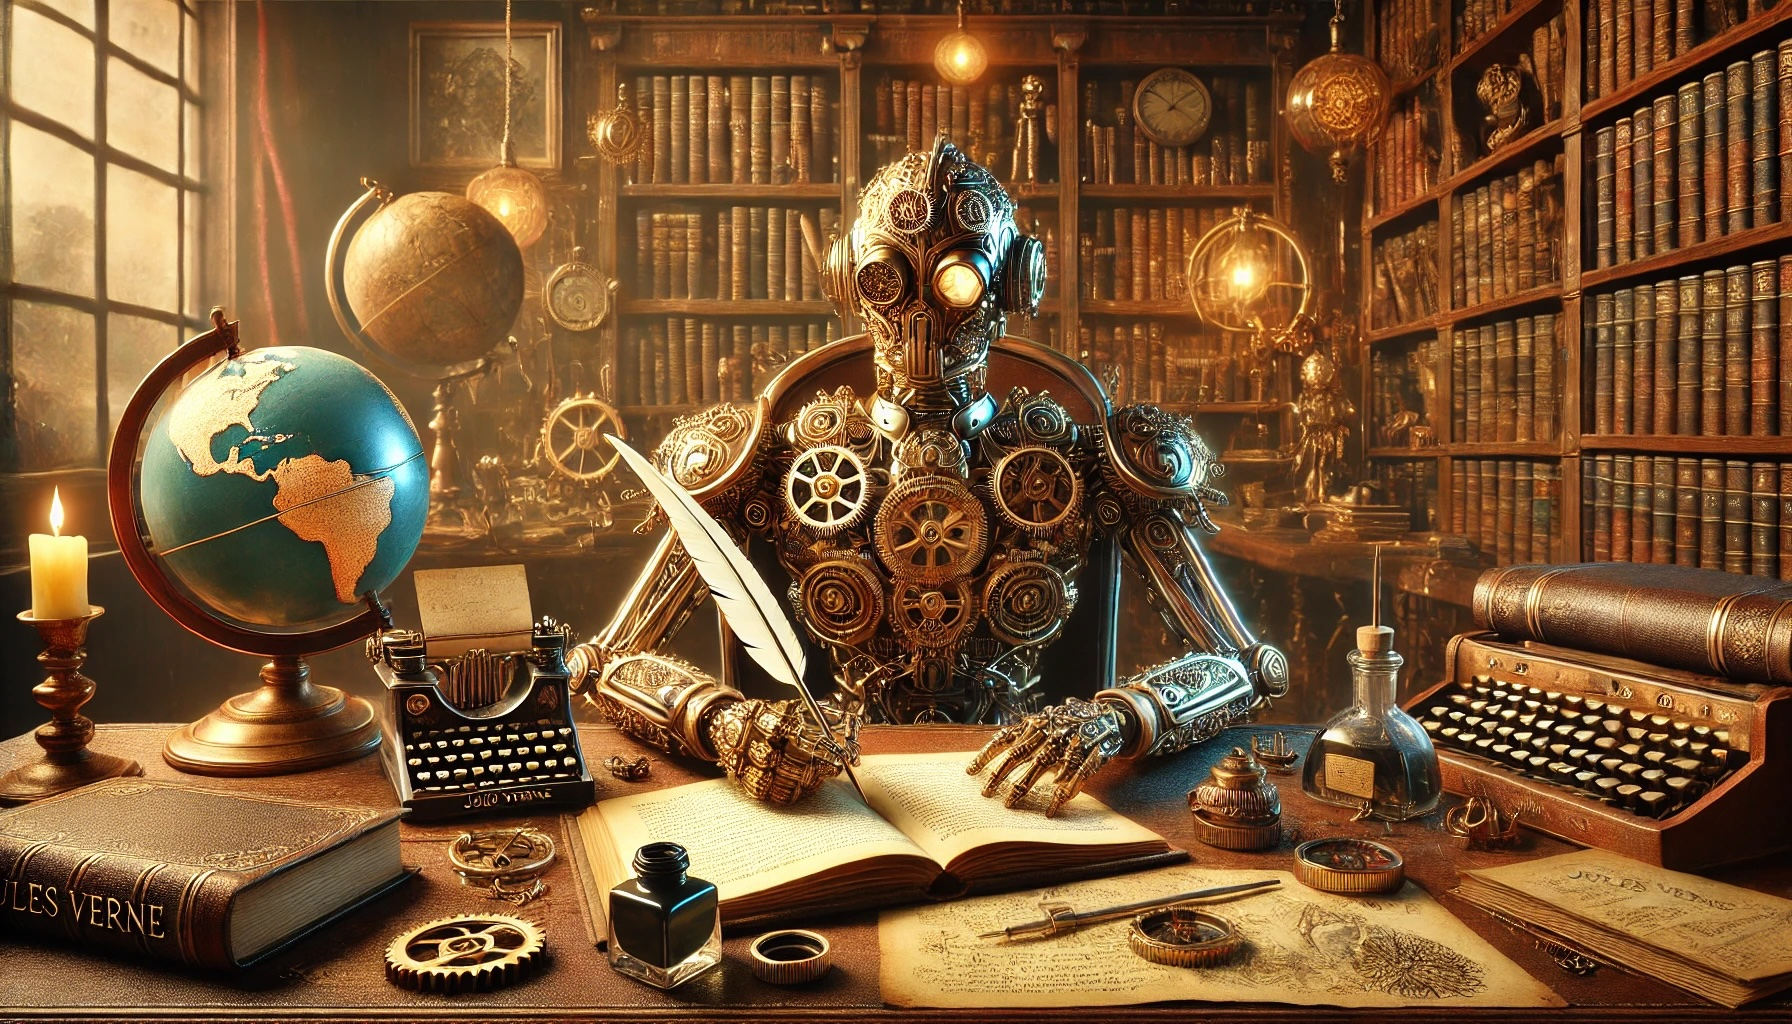

In this notebook, we have the main steps involved in developing and training a character-level language model based on Jules Verne's books. The steps form the basis of understanding and presenting large language models (LLMs) using a simpler example of Jules Verne text generation.

- The Artificial network developed on this project, generates text, character by character. Please see this following site, for a great general visual explanation, see from Andrej Karpathy, [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

## Main Libraries



In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.saving import register_keras_serializable

In [2]:
print(tf.__version__)

2.17.0


## Data Preparation
   - **Task**: Gather and preprocess the data.
     - **Example**: For the Jules Verne text generation, we collect his books, in text format. The text is processed by removing irrelevant characters (e.g., line breaks or non-standard symbols) and converting it into a format suitable for machine learning.
   - **Key Considerations**: Data cleaning is crucial, and you ensure the text is structured for analysis.

- Jules Verne original XIX century books can be downloaded from: [Gutenberg Project](https://www.gutenberg.org/ebooks/search/?query=jules+verne&submit_search=Go%21)

In [3]:
ls ./books/

'A Journey to the Centre of the Earth.txt'  'In Search of the Castaways.txt'
'An Antarctic Mystery.txt'                  'In the year 2889.txt'
'Around the World in Eighty Days.txt'       'Michael Strogoff.txt'
'Five Weeks in a Balloon.txt'               'The Mysterious Island.txt'
'From the Earth to the Moon.txt'            'Twenty Thousand Leagues under the Sea.txt'


In [57]:
# Read all the text files
path = './books/'
text = ""
# Iterate over all .txt files in the specified folder
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        # Read the content of each text file and append it to the concatenated_text variable
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
            text += file.read() + "\n"  # Adding newline for separation between books


print(f"Total characters: {len(text)}")

Total characters: 5768791


In [58]:
print(text[:2500])

﻿The Project Gutenberg eBook of In the year 2889
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: In the year 2889

Author: Michel Verne
        Jules Verne

Release date: September 23, 2006 [eBook #19362]
                Most recently updated: January 1, 2021

Language: English

Credits: Produced by Norm Wolcott


*** START OF THE PROJECT GUTENBERG EBOOK IN THE YEAR 2889 ***




Produced by Norm Wolcott






IN THE YEAR 2889

By Jules Verne and Michel Verne



[Redactor's note: _In the Year 2889_ was first published in the
_Forum_, February, 1889; p. 662. It was published in France th

### Tokenization and Vocabulary
   - **Task**: Convert the text into tokens.
     - **Example**: In this case, we will use **character-level tokenization**, where each unique character from the text becomes a part of the vocabulary. The vocabulary contained **117 unique characters**.
     - **Mapping**: Each character is assigned an index (e.g., 'A' → 35).
     - **Importance**: Tokenization allows the model to process text efficiently, turning the text into numerical data that it can understand and learn from.
     - **Example of mapping**: `"The Project"` → `[122  52  69  66   1  48  79  76  71  66  64  81]`

In [6]:
# Create vocabulary of unique characters
vocab = sorted(set(text))
print(f"Unique characters: {len(vocab)}")

Unique characters: 123


In [21]:
print(vocab)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '£', '°', '½', 'À', 'Æ', 'Ê', 'à', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ï', 'ñ', 'ô', 'û', 'ü', 'Œ', 'œ', 'δ', '—', '‘', '’', '“', '”', '•', '′', '″', '™', '\ufeff']


In [25]:
# Creating a mapping from unique characters to indices
char_to_ind = {char:ind for ind, char in enumerate(vocab)}
print(char_to_ind)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, 'A': 33, 'B': 34, 'C': 35, 'D': 36, 'E': 37, 'F': 38, 'G': 39, 'H': 40, 'I': 41, 'J': 42, 'K': 43, 'L': 44, 'M': 45, 'N': 46, 'O': 47, 'P': 48, 'Q': 49, 'R': 50, 'S': 51, 'T': 52, 'U': 53, 'V': 54, 'W': 55, 'X': 56, 'Y': 57, 'Z': 58, '[': 59, ']': 60, '_': 61, 'a': 62, 'b': 63, 'c': 64, 'd': 65, 'e': 66, 'f': 67, 'g': 68, 'h': 69, 'i': 70, 'j': 71, 'k': 72, 'l': 73, 'm': 74, 'n': 75, 'o': 76, 'p': 77, 'q': 78, 'r': 79, 's': 80, 't': 81, 'u': 82, 'v': 83, 'w': 84, 'x': 85, 'y': 86, 'z': 87, '{': 88, '}': 89, '~': 90, '£': 91, '°': 92, '½': 93, 'À': 94, 'Æ': 95, 'Ê': 96, 'à': 97, 'â': 98, 'æ': 99, 'ç': 100, 'è': 101, 'é': 102, 'ê': 103, 'ë': 104, 'ï': 105, 'ñ': 106, 'ô': 107, 'û': 108, 'ü': 109, 'Œ': 110

In [26]:
char_to_ind['A']

33

In [27]:
ind_to_char = np.array(vocab)
ind_to_char

array(['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
       ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F',
       'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S',
       'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~',
       '£', '°', '½', 'À', 'Æ', 'Ê', 'à', 'â', 'æ', 'ç', 'è', 'é', 'ê',
       'ë', 'ï', 'ñ', 'ô', 'û', 'ü', 'Œ', 'œ', 'δ', '—', '‘', '’', '“',
       '”', '•', '′', '″', '™', '\ufeff'], dtype='<U1')

In [28]:
ind_to_char[33]

'A'

In [29]:
# Convert full text to integer representation
encoded_text = np.array([char_to_ind[c] for c in text])
encoded_text

array([122,  52,  69, ...,   0,   0,   0])

In [32]:
print(text [:12])
print(encoded_text [:12])

﻿The Project
[122  52  69  66   1  48  79  76  71  66  64  81]


In [33]:
encoded_text.shape

(5768791,)

We now have a mapping we can use to go back and forth from characters to numerics.

In [45]:
sample = text[1220:1900]
print(sample)



IN THE YEAR 2889.

Little though they seem to think of it, the people of this twenty-ninth
century live continually in fairyland. Surfeited as they are with
marvels, they are indifferent in presence of each new marvel. To them
all seems natural. Could they but duly appreciate the refinements of
civilization in our day; could they but compare the present with the
past, and so better comprehend the advance we have made! How much fairer
they would find our modern towns, with populations amounting sometimes
to 10,000,000 souls; their streets 300 feet wide, their houses 1000 feet
in height; with a temperature the same in all seasons; with their lines
of aërial locomotion cro


In [46]:
encoded_text[1220:1900]

array([  0,   0,  41,  46,   1,  52,  40,  37,   1,  57,  37,  33,  50,
         1,  19,  25,  25,  26,  15,   0,   0,  44,  70,  81,  81,  73,
        66,   1,  81,  69,  76,  82,  68,  69,   1,  81,  69,  66,  86,
         1,  80,  66,  66,  74,   1,  81,  76,   1,  81,  69,  70,  75,
        72,   1,  76,  67,   1,  70,  81,  13,   1,  81,  69,  66,   1,
        77,  66,  76,  77,  73,  66,   1,  76,  67,   1,  81,  69,  70,
        80,   1,  81,  84,  66,  75,  81,  86,  14,  75,  70,  75,  81,
        69,   0,  64,  66,  75,  81,  82,  79,  86,   1,  73,  70,  83,
        66,   1,  64,  76,  75,  81,  70,  75,  82,  62,  73,  73,  86,
         1,  70,  75,   1,  67,  62,  70,  79,  86,  73,  62,  75,  65,
        15,   1,  51,  82,  79,  67,  66,  70,  81,  66,  65,   1,  62,
        80,   1,  81,  69,  66,  86,   1,  62,  79,  66,   1,  84,  70,
        81,  69,   0,  74,  62,  79,  83,  66,  73,  80,  13,   1,  81,
        69,  66,  86,   1,  62,  79,  66,   1,  70,  75,  65,  7

### Training Sequences

Overall what we are trying to achieve is to have the model predict the next highest probability character given a historical sequence of characters. Its up to us (the user) to choose how long that historic sequence. Too short a sequence and we don't have enough information (e.g. given the letter "a" , what is the next character) , too long a sequence and training will take too long and most likely overfit to sequence characters that are irrelevant to characters farther out. While there is no correct sequence length choice, you should consider the text itself, how long normal phrases are in it, and a reasonable idea of what characters/words are relevant to each other.

The actual text data will be the text sequence shifted one character forward. For example:

Sequence In: "Hello my nam"
Sequence Out: "ello my name"


We can use the `tf.data.Dataset.from_tensor_slices` function to convert a text vector into a stream of character indices.

In [ ]:
linelen(line)

In [11]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [48]:
seq_len = 120
total_num_seq = len(text)//(seq_len+1)
total_num_seq

47675

In [49]:
# Create Training Sequences
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)

The **batch** method converts these individual character calls into sequences we can feed in as a batch. We use seq_len+1 because of zero indexing. Here is what drop_remainder means:

drop_remainder: (Optional.) A `tf.bool` scalar `tf.Tensor`, representing
    whether the last batch should be dropped in the case it has fewer than
    `batch_size` elements; the default behavior is not to drop the smaller
    batch.


In [50]:
sequences = char_dataset.batch(seq_len+1, drop_remainder=True)

Now that we have our sequences, we will perform the following steps for each one to create our target text sequences:

1. Grab the input text sequence
2. Assign the target text sequence as the input text sequence shifted by one step forward
3. Group them together as a tuple

In [51]:
def create_seq_targets(seq): # Hello my name
    input_txt = seq[:-1]     # Hello my nam
    target_txt = seq[1:]     # ello my name
    return input_txt, target_txt

In [52]:
dataset = sequences.map(create_seq_targets)

In [59]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(120,), dtype=tf.int64, name=None), TensorSpec(shape=(120,), dtype=tf.int64, name=None))>

In [61]:
# For testing
for input_txt, target_txt in  dataset.take(3):
    print(input_txt.numpy())
    print(''.join(ind_to_char[input_txt.numpy()]))
    print('\n')
    print(target_txt.numpy())
    # There is an extra whitespace!
    print(''.join(ind_to_char[target_txt.numpy()]))

[122  52  69  66   1  48  79  76  71  66  64  81   1  39  82  81  66  75
  63  66  79  68   1  66  34  76  76  72   1  76  67   1  41  75   1  81
  69  66   1  86  66  62  79   1  19  25  25  26   0   1   1   1   1   0
  52  69  70  80   1  66  63  76  76  72   1  70  80   1  67  76  79   1
  81  69  66   1  82  80  66   1  76  67   1  62  75  86  76  75  66   1
  62  75  86  84  69  66  79  66   1  70  75   1  81  69  66   1  53  75
  70  81  66  65   1  51  81  62  81  66  80   1]
﻿The Project Gutenberg eBook of In the year 2889
    
This ebook is for the use of anyone anywhere in the United States 


[52 69 66  1 48 79 76 71 66 64 81  1 39 82 81 66 75 63 66 79 68  1 66 34
 76 76 72  1 76 67  1 41 75  1 81 69 66  1 86 66 62 79  1 19 25 25 26  0
  1  1  1  1  0 52 69 70 80  1 66 63 76 76 72  1 70 80  1 67 76 79  1 81
 69 66  1 82 80 66  1 76 67  1 62 75 86 76 75 66  1 62 75 86 84 69 66 79
 66  1 70 75  1 81 69 66  1 53 75 70 81 66 65  1 51 81 62 81 66 80  1 62]
The Project Gutenberg e

### Generating training batches

Now that we have the actual sequences, we will create the batches, we want to shuffle these sequences into a random order, so the model doesn't overfit to any section of the text, but can instead generate characters given any seed text.

Using a `seq_leng` of 150 provides the context for the model to learn from (around one paragraph).

Now, let's discuss the parameters:

1. `seq_leng = 150`: It means each training example will consist of 150 characters, and the model will try to predict the 151st character.

2. `buffer_size = 10000`: This to be the number of unique sequences in the dataset.

3. `batchsize = 128`: This is generally a good default value. It's large enough to take advantage of vectorization but small enough to fit in memory on most systems. We can adjust this based on your available memory and processing power. If we have a GPU with more memory, you might increase this to 256.





In [62]:
# Batch size
batch_size = 128

# Buffer size to shuffle the dataset so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in which it shuffles elements
buffer_size = 10000

dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

In [63]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(128, 120), dtype=tf.int64, name=None), TensorSpec(shape=(128, 120), dtype=tf.int64, name=None))>

## Model Creation

Parameters to consider when we move to model creation and training:

- `embedding_dim`: This is set to 256, which is usually sufficient, but we can increase it to 512 if we want to capture more nuanced relationships between characters.

- `rnn_neurons`: This was set to 1024, which is a good value for a dataset of our size. We can experiment with 512 or 2048 to see if it affects the quality of our generated text.

### Embedding
   - **Task**: Represent each token as a dense vector.
     - **Example**: After tokenization, each character is converted into a 256-dimensional vector using an **embedding layer**.
     - **Explanation**: The embedding captures relationships between characters. For example, similar characters may have embeddings that are closer in vector space.
     - **Visualization**: A 2D or 3D projection of these vectors using techniques like t-SNE or UMAP can help illustrate how the characters are related (Code and examples at the end of this notebook).

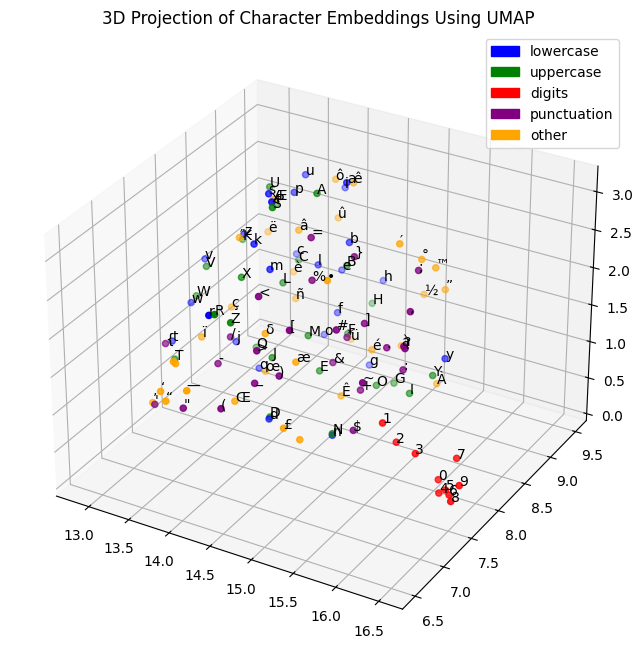

### Model Architecture
   - **Task**: Build the model.
     - **Example**: We will construct a sequential model with three layers:
       1. **Embedding layer**: Transforms characters into dense vectors.
       2. **GRU (Gated Recurrent Unit)** layer: Handles sequences of tokens and learns from context. We use **1024 units** to capture long-term dependencies in the text.
       3. **Dense layer**: Outputs probabilities for each character in the vocabulary.
     - **Importance**: The GRU layer helps in learning sequential patterns in the text, which is critical for generating coherent text based on previous characters.

---

In [65]:
def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

In [69]:
def create_model(vocab_size, embed_dim, rnn_neurons):
    model = Sequential()
    model.add(Embedding(vocab_size,
                        embed_dim,
    ))
    model.add(GRU(rnn_neurons,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'))
    # Final Dense Layer to Predict
    model.add(Dense(vocab_size))
    model.compile(optimizer='adam', loss=sparse_cat_loss)
    return model

In [71]:
def create_model(vocab_size, embed_dim, rnn_neurons):
    model = Sequential([
        Embedding(vocab_size,
                  embed_dim,
                  input_length=None),  # Flexible input length
        GRU(rnn_neurons,
            return_sequences=True,
            recurrent_initializer='glorot_uniform'),
        Dense(vocab_size)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=sparse_cat_loss)
    return model

In [73]:
# Set up parameters
vocab_size = len(vocab)
embed_dim = 256
rnn_neurons = 1024

model = create_model(vocab_size, embed_dim, rnn_neurons)

# Build the model with a sample input shape
sample_input = tf.zeros((1, seq_length))
model(sample_input)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (1, 120, 256)               │          31,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (1, 120, 1024)              │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (1, 120, 123)               │         126,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,095,867 (15.62 MB)

 Trainable params: 4,095,867 (15.62 MB)

 Non-trainable params: 0 (0.00 B)

## Training


   - **Task**: Train the model using a loss function and optimizer.
     - **Example**:
       - **Loss Function**: Sparse Categorical Crossentropy, which compares the model’s predictions with the actual next character.
       - **Optimizer**: Adam (a widely used optimizer for deep learning).
       - **Epochs**: 50 training cycles with a **batch size** of 64 were used.
     - **Monitoring**: We monitore loss reduction over epochs, and observed a steady decrease from 2.88 to 0.45 across 50 epochs.
     - **Visual**: Show a loss curve to demonstrate how the model improves over time.


In [74]:
for input_example_batch, target_example_batch in dataset.take(1):

  # Predict off some random batch
  example_batch_predictions = model(input_example_batch)

  # Display the dimensions of the predictions
  print(example_batch_predictions.shape, " <=== (batch_size, sequence_length, vocab_size)")


(128, 120, 123)  <=== (batch_size, sequence_length, vocab_size)


In [75]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)

In [76]:
# Reformat to not be a lists of lists
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [77]:
print("Given the input seq: \n")
print("".join(ind_to_char[input_example_batch[0]]))
print('\n')
print("Next Char Predictions: \n")
print("".join(ind_to_char[sampled_indices ]))

Given the input seq: 

he
disinflated covering, bore them away toward the northern part of the
lake.

“Lost!” exclaimed the sportsman, with a g


Next Char Predictions: 

d'(.i="ÆZ/?_6-1t"kéYüS<c4èê?ûBA″R]y<$LCgyx5>+ô ,V'SéN8“HÆ/DO2k=ëD″ñQj°< sv°c?EnôPê i>A:‘z!I7ZQSXâsu&”AhzQœ6e#ûS'4%8"Pg!}


In [79]:
epochs = 30
history = model.fit(dataset,epochs=epochs)

Epoch 1/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 54s 136ms/step - loss: 2.3934
Epoch 2/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - loss: 1.3610
Epoch 3/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - loss: 1.2118
Epoch 4/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step - loss: 1.1472
Epoch 5/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 83s 137ms/step - loss: 1.1048
Epoch 6/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 1.0733
Epoch 7/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 80s 131ms/step - loss: 1.0470
Epoch 8/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - loss: 1.0254
Epoch 9/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - loss: 1.0051
Epoch 10/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - loss: 0.9870
Epoch 11/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - loss: 0.9719
Epoch 12/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 84s 137ms/step - loss: 0.9586
Epoch 13/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - loss: 0.9459
Epoch 14/30
372/372 ━━━━━━━━━━━━━━━━━━━━ 84s 137ms/step - loss: 0.9334
Epoch 15/30
372

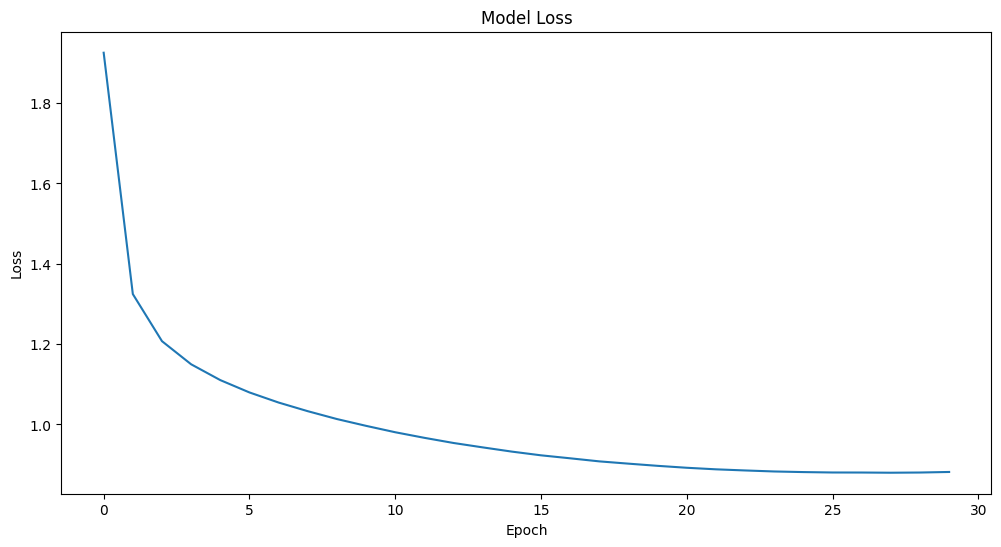

In [80]:
# Plot the training curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

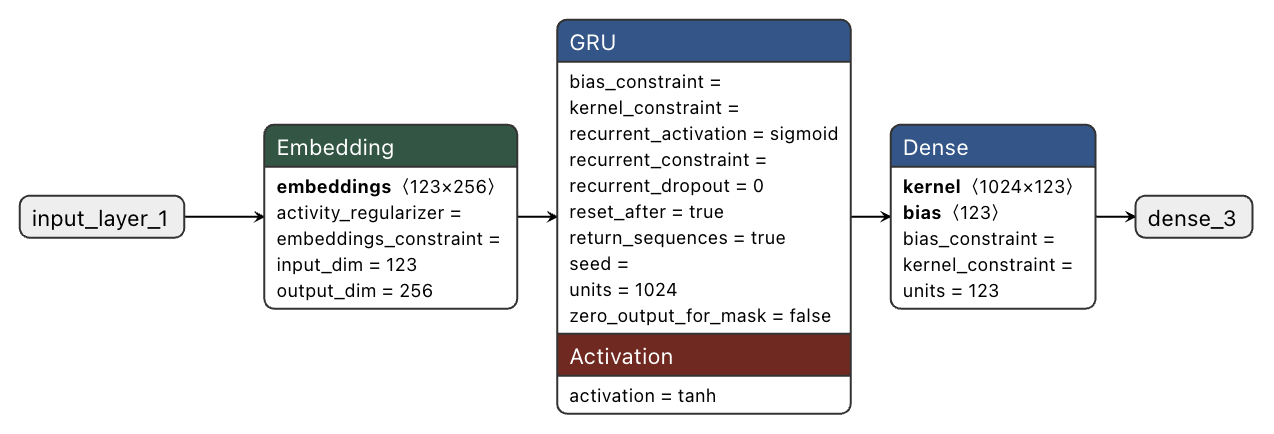

In [81]:
model.save('verne_rnn_model.keras')

In [82]:
loaded_model = load_model('verne_rnn_model.keras', custom_objects={'sparse_cat_loss': sparse_cat_loss})

In [83]:
# Save weights
model.save_weights('verne_rnn_weights.weights.h5')

In [84]:
loaded_model

<Sequential name=sequential_4, built=True>

## Text Generation

 - **Task**: Generate text using the trained model.
     - **Example**: Start with a seed text like "A Luva" and generate subsequent characters one by one. We introduce **temperature** to control the creativity of the output:
       - **Low temperature (0.5)**: More predictable and conservative text.
       - **Medium temperature (0.7)**: Balanced generation.
       - **High temperature (1.0)**: More random, sometimes incoherent output.
     - **Example Output**: We generate text samples with different temperatures to illustrate how varying the temperature influences the creativity of the output.

In [89]:
def generate_text(model, start_string, char2idx, idx2char, num_generate=1000, temperature=0.7):
    '''
    model: Trained Model to Generate Text
    start_string: Intial Seed text in string form
    num_generate: Number of characters to generate

    Basic idea behind this function is to take in some seed text, format it so
    that it is in the correct shape for our network, then loop the sequence as
    we keep adding our own predicted characters.
    '''

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    for i in range(num_generate):
        predictions = model(input_eval)
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Append the predicted character to the input for the next iteration
        input_eval = tf.concat([input_eval, tf.expand_dims([predicted_id], 0)], axis=-1)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))



In [91]:
# Generate text with different temperatures
temperatures = [0.5, 0.7, 1.0]
start_string = "THE FLYING SUBMARINE"
for temp in temperatures:
    print(f"\nGenerated text with temperature {temp}:\n")
    generated_text = generate_text(model, start_string,
                                   char_to_ind, ind_to_char,
                                   num_generate=2000,
                                   temperature=temp)
    print(generated_text)
    print("-" * 50)


Generated text with temperature 0.5:

THE FLYING SUBMARINE

CHAPTER 100 VENTANTILE           This eBook is for the use of
anyone anywhere in the United States and most other parts of the earth and
miserable eruptions. The solar rays should be entirely under the shock
of the intensity of the sea. We were all sorts. Are we to prepare for our
feelings?"

"I can never see them a good geographer," said Mary.

"Well, then, John, for I get to the Pampas, that we ought to obey the same
time. In the country of this latitude changed my brother, and the
_Nautilus_ floated in a sea which contained the rudder and
lower colour visibly. The loiter was a fatalint region the two
scientific discoverers. Several times turning toward the river, the cry
of doors and over an inclined plains of the Angara, with a threatening
water and disappeared in the midst of the solar rays.

The weather was spread and strewn with closed bottoms which soon appeared
that the unexpected sheets of wind was soon and linen, a

## Export model and training results to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!scp -r /content '/content/gdrive/MyDrive/LLMs/VerneBot'

## Challenges and Limitations
   - **Task**: Address the issues with the model.
     - **Example**:
       - **Limited context window**: The model only uses a fixed number of previous characters (150 in this case), limiting its ability to capture long-term dependencies in the text.
       - **Lack of coherence**: The model may generate grammatically correct text but struggle with maintaining a coherent narrative over long paragraphs.
     - **Character-level modeling**: Although character-level models work well, word-level tokenization could improve coherence and reduce complexity.

## Bridging to Modern LLMs
   - **Task**: Compare the simple model to modern LLMs.
     - **Example**:
       - **Scale**: Our character-level model (with **4 million parameters**) is small compared to models like GPT-3, which has **175 billion parameters**, or Llama 3.1 with its **405 billion parameter**.
       - **Architecture**: Modern models use the Transformer architecture, which excels in handling long-range dependencies.
       - **Tokenization**: Instead of characters, modern LLMs often use **subword tokenization**, which helps balance between handling rare words and common words more efficiently.
     - **Key Takeaway**: The step from a simple character-level model to a modern LLM involves improvements in scale, architecture, and tokenization.

### Future Directions
   - **Task**: Discuss improvements.
     - **Examples**:
       - **Word-level tokenization**: Shifting from characters to words or subwords.
       - **Attention mechanisms**: Introducing attention layers, which allow models to focus on important parts of the input sequence.
       - **Fine-tuning larger models**: Using pre-trained models for Portuguese, like **BERTimbau**, to fine-tune with specific literary styles.


## Embeddings Visualization

In [93]:
#char2idx = {u: i for i, u in enumerate(vocab)}  # vocabulary from tokenization
#idx2char = np.array(vocab)

# Extract the embeddings from the embedding layer of your trained model
embedding_layer = model.get_layer('embedding_4')
embedding_weights = embedding_layer.get_weights()[0]

print("Embedding shape:", embedding_weights.shape)  # Should print (vocab_size, embedding_dim)

Embedding shape: (123, 256)


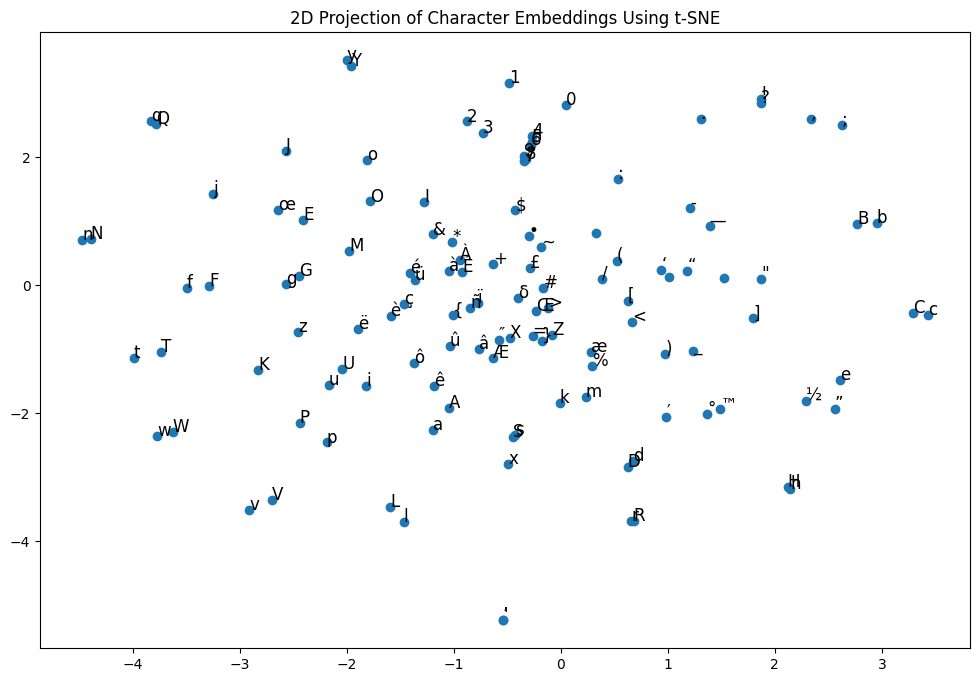

In [94]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding_weights)

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])

# Annotate points with characters
for i, char in enumerate(idx2char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=12)

plt.title("2D Projection of Character Embeddings Using t-SNE")
plt.show()

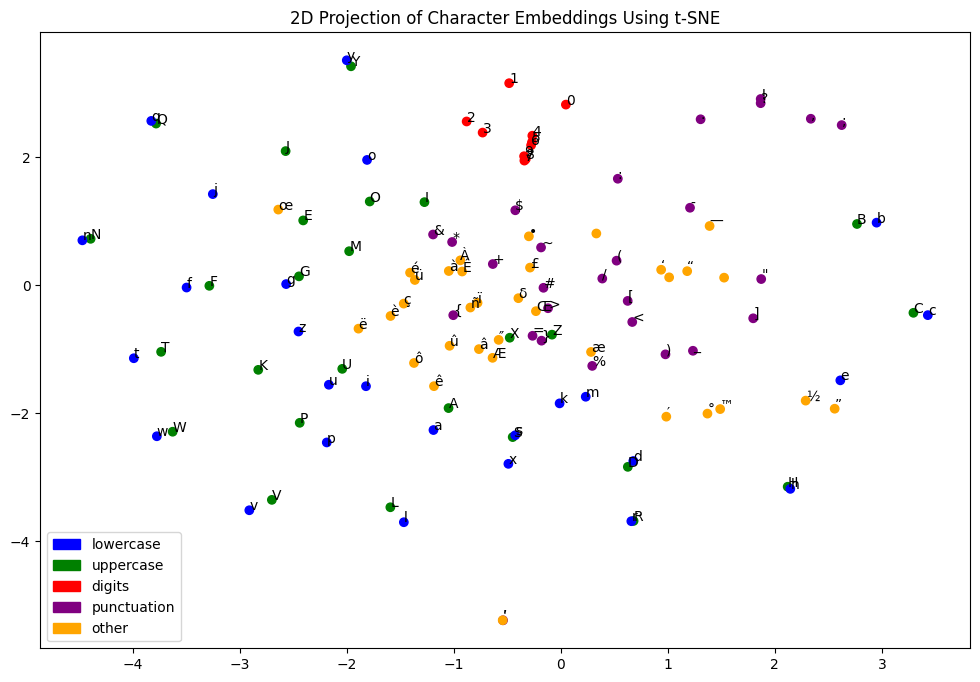

In [97]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply t-SNE to the embeddings
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in idx2char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Plot the results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)

# Annotate points with characters
for i, char in enumerate(ind_to_char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

plt.title("2D Projection of Character Embeddings Using t-SNE")
plt.show()


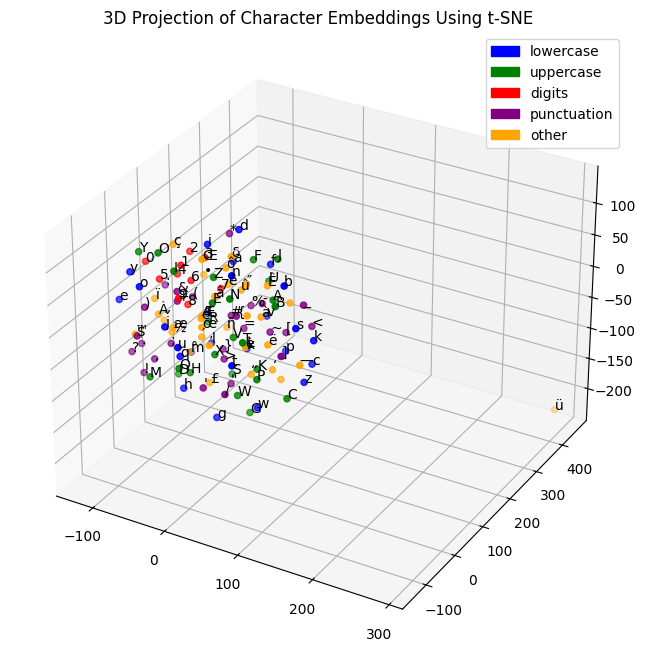

In [98]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import string
from mpl_toolkits.mplot3d import Axes3D

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply t-SNE to the embeddings (now in 3D)
tsne = TSNE(n_components=3, random_state=42)
embedding_3d = tsne.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in ind_to_char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=colors)

# Annotate points with characters
for i, char in enumerate(ind_to_char):
    ax.text(embedding_3d[i, 0], embedding_3d[i, 1], embedding_3d[i, 2], char, fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

ax.set_title("3D Projection of Character Embeddings Using t-SNE")
plt.show()


In [99]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


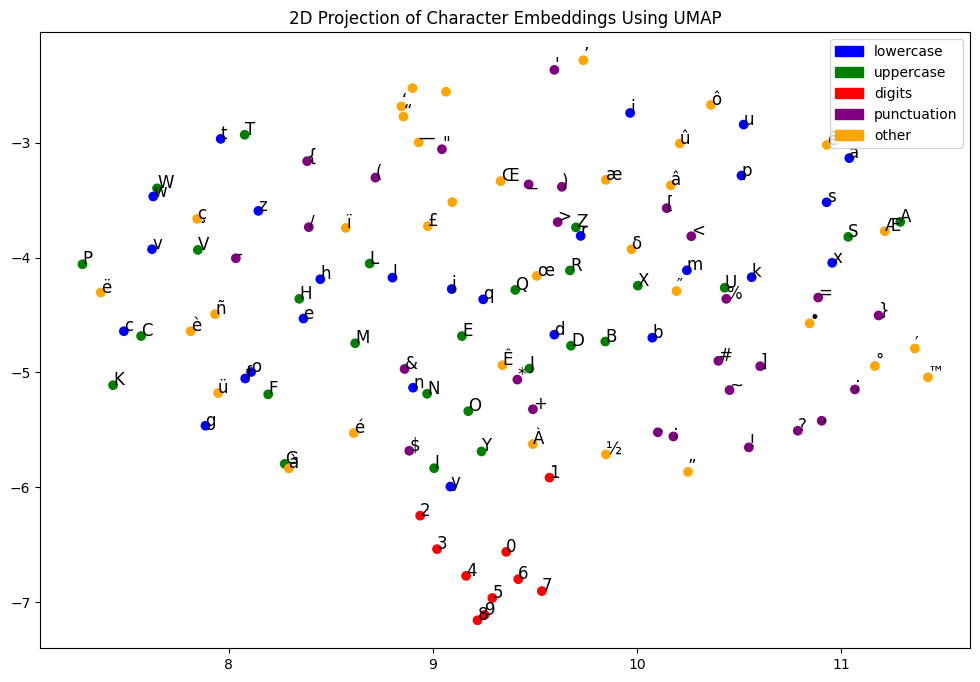

In [101]:
import umap
import matplotlib.pyplot as plt
import string

# Character categories
lowercase = string.ascii_lowercase
uppercase = string.ascii_uppercase
digits = string.digits
punctuation = string.punctuation

# Apply UMAP to the embeddings (for 2D projection)
umap_2d = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_2d.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in ind_to_char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Plot the 2D UMAP projection
plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors)

# Annotate points with characters
for i, char in enumerate(ind_to_char):
    plt.annotate(char, (embedding_2d[i, 0], embedding_2d[i, 1]), fontsize=12)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

plt.title("2D Projection of Character Embeddings Using UMAP")
plt.show()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


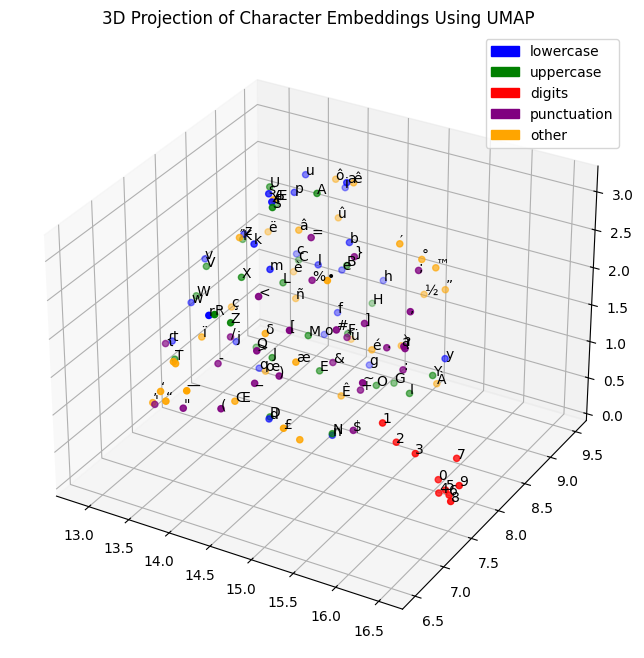

In [102]:
import umap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import string

# Apply UMAP to the embeddings (for 3D projection)
umap_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = umap_3d.fit_transform(embedding_weights)

# Group characters by category and assign colors
char_categories = []
colors = []
for char in ind_to_char:
    if char in lowercase:
        char_categories.append('lowercase')
        colors.append('blue')
    elif char in uppercase:
        char_categories.append('uppercase')
        colors.append('green')
    elif char in digits:
        char_categories.append('digits')
        colors.append('red')
    elif char in punctuation:
        char_categories.append('punctuation')
        colors.append('purple')
    else:
        char_categories.append('other')
        colors.append('orange')  # For any other characters (e.g., space, newline)

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=colors)

# Annotate points with characters
for i, char in enumerate(ind_to_char):
    ax.text(embedding_3d[i, 0], embedding_3d[i, 1], embedding_3d[i, 2], char, fontsize=10)

# Create a custom legend
import matplotlib.patches as mpatches
legend_labels = {
    'lowercase': 'blue',
    'uppercase': 'green',
    'digits': 'red',
    'punctuation': 'purple',
    'other': 'orange'
}
handles = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=handles)

ax.set_title("3D Projection of Character Embeddings Using UMAP")
plt.show()
